# Anomaly detection using Autoencoders

In this example, we try to detect anomalies in ECG data using an Autoencoder. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

tf.enable_eager_execution()
#tf.compat.v1.enable_eager_execution

In [2]:
# Download the dataset
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
print(data.shape)
data.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Split and format the data

In [3]:
# last column is the target: 0 = anomaly, 1 = normal
TARGET = data.shape[1]-1

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)

In [4]:
# use case is novelty detection so use only the normal data for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

print("Number of use cases: ", len(train_index.tolist()))

Number of use cases:  2335


## Scale the data

In [5]:
# scale betwee [0 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# show training data shape
x_train_scaled.shape

(2335, 140)

## Plot the scaled data

In [6]:
# normal data
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]
normal_train_data = pd.DataFrame(train_data)
nd_subset = normal_train_data.iloc[0:5]

# get anomaly data
anom_index = y_train[y_train == 0].index
an = x_train.loc[anom_index]
anomaly_train_data = pd.DataFrame(an)
ad_subset = anomaly_train_data .iloc[0:5]

Text(0.5, 1.0, 'Anomaly Data')

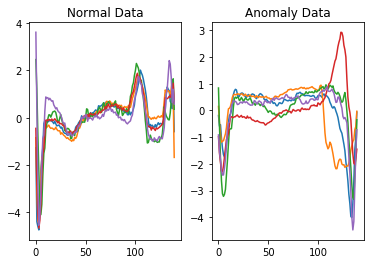

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(nd_subset.T)
ax1.set_title("Normal Data")

ax2.plot(ad_subset.T)
ax2.set_title("Anomaly Data")

## 1. Build the Autoencoder model

Create an autoencoder class and train the model.

In [8]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    # define encoder part -> relu layers 64-32-16 
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    # define decoder part -> relu layers 16-32-64
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

## Train the Autoencoder

In [9]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])

# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Train on 2335 samples, validate on 1000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
2335/2335 [==============================] - 1s 417us/sample - loss: 0.0111 - mean_squared_error: 0.0249 - val_loss: 0.0136 - val_mean_squared_error: 0.0316
Epoch 2/20
2335/2335 [==============================] - 0s 20us/sample - loss: 0.0105 - mean_squared_error: 0.0236 - val_loss: 0.0132 - val_mean_squared_error: 0.0308
Epoch 3/20
2335/2335 [==============================] - 0s 19us/sample - loss: 0.0096 - mean_squared_error: 0.0216 - val_loss: 0.0130 - val_mean_squared_error: 0.0301
Epoch 4/20
2335/2335 [==============================] - 0s 18us/sample - loss: 0.0087 - mean_squared_error: 0.0195 - val_loss: 0.0125 - val_mean_squared_error: 0.0292
Epoch 5/20
2335/2335 [==============================] - 0s 20us/sample - loss: 0.0077 - mean_squared_error: 0.0173 - val_loss: 0.0121 - val_mean_squared_error: 0.0282
Epoch 6/20
2335/2335 [

## Plot history

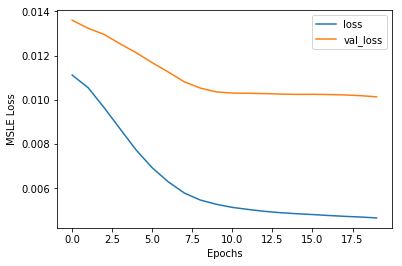

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Find threshold

Find suitable threshold for anomaly scores

In [11]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
    + np.std(reconstruction_errors.numpy())
    return threshold

def find_threshold_method_two(model, x_train_scaled):
    # another method to find threshold
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    threshold_2 = np.percentile(reconstruction_errors, 95)
    return threshold_2

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

In [12]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

Threshold method one: 0.009992843454885006
Threshold method two: 0.014339122856651437


In [13]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

0.931

# 2. Tune Autoencoder using Keras tuner

In this section, we try Keras' hyperparameter tuning framework. It's a scalable hyperparameter optimization framework for hyperparameter search, i.e., it finds the best hyperparameter values for a given model.

In [14]:
# Make sure to install keras-tuner
#!pip install -U keras-tuner

In [15]:
import keras_tuner as kt

In [16]:
# Redefine autoencoder class to search for best number of units to use in each layer
class AutoEncoderTuner(Model):

    def __init__(self, hp, output_units, code_size=8):
        super().__init__()
        # hyperparameters (hp) being searched - with range [16, 72] in steps/increments of 4 
        dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
        dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
        dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
        dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
        dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
        dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
        self.encoder = Sequential([
          Dense(dense_1_units, activation='relu'),
          Dropout(0.1),
          Dense(dense_2_units, activation='relu'),
          Dropout(0.1),
          Dense(dense_3_units, activation='relu'),
          Dropout(0.1),
          Dense(code_size, activation='relu')
        ])
        
        self.decoder = Sequential([
          Dense(dense_4_units, activation='relu'),
          Dropout(0.1),
          Dense(dense_5_units, activation='relu'),
          Dropout(0.1),
          Dense(dense_6_units, activation='relu'),
          Dropout(0.1),
          Dense(output_units, activation='sigmoid')
        ])
  
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


def build_model(hp):
    model = AutoEncoderTuner(hp, 140)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='msle', optimizer= Adam(learning_rate=hp_learning_rate),)
    return model

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

INFO:tensorflow:Reloading Oracle from existing project autoencoder\tuning_autoencoder6\oracle.json
INFO:tensorflow:Reloading Tuner from autoencoder\tuning_autoencoder6\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [18]:
# Display the best hyperparameters found for each layer
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 56
dense_2_units: 44
dense_3_units: 32
dense_4_units: 40
dense_5_units: 60
dense_6_units: 20
learning_rate: 0.01


In [19]:
# Apply test data to best model
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

history = best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Train on 2335 samples, validate on 1000 samples
Epoch 1/20
2335/2335 [==============================] - 1s 405us/sample - loss: 0.0041 - val_loss: 0.0099
Epoch 2/20
2335/2335 [==============================] - 0s 19us/sample - loss: 0.0039 - val_loss: 0.0097
Epoch 3/20
2335/2335 [==============================] - 0s 17us/sample - loss: 0.0038 - val_loss: 0.0096
Epoch 4/20
2335/2335 [==============================] - 0s 20us/sample - loss: 0.0036 - val_loss: 0.0095
Epoch 5/20
2335/2335 [==============================] - 0s 17us/sample - loss: 0.0035 - val_loss: 0.0094
Epoch 6/20
2335/2335 [==============================] - 0s 18us/sample - loss: 0.0034 - val_loss: 0.0093
Epoch 7/20
2335/2335 [==============================] - 0s 20us/sample - loss: 0.0034 - val_loss: 0.0092
Epoch 8/20
2335/2335 [==============================] - 0s 20us/sample - loss: 0.0033 - val_loss: 0.0092
Epoch 9/20
2335/2335 [==============================] - 0s 19us/sample - loss: 0.0032 - val_loss: 0.0091
Epoch 

In [20]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)

0.947